In [2]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
climate_train= pd.read_csv('DailyDelhiClimateTrain.csv')
climate_test= pd.read_csv('DailyDelhiClimateTest.csv')
gabung = [climate_train, climate_test]
data = pd.concat(gabung)
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1576 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1576 non-null   object 
 1   meantemp      1576 non-null   float64
 2   humidity      1576 non-null   float64
 3   wind_speed    1576 non-null   float64
 4   meanpressure  1576 non-null   float64
dtypes: float64(4), object(1)
memory usage: 73.9+ KB


In [ ]:
data.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [6]:
dates = data["date"].values
temp = data["meantemp"].values

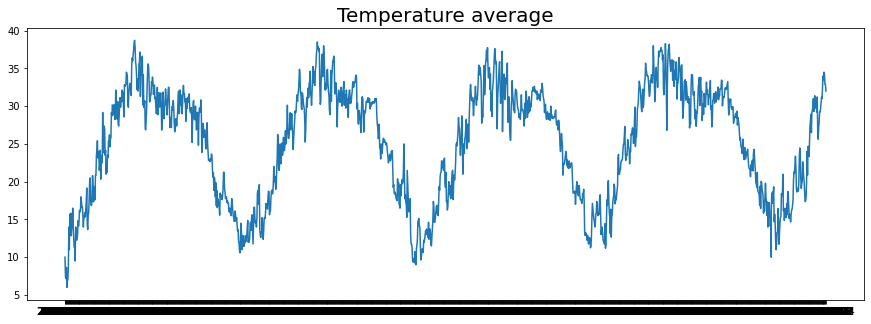

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
from sklearn.model_selection import train_test_split
data_latih, data_test, label_latih, label_test = train_test_split(dates, temp, test_size=0.2)

In [9]:
train_set = windowed_dataset(label_latih, window_size=60, batch_size=80, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [10]:
train_set = windowed_dataset(label_latih, window_size=60, batch_size=80, shuffle_buffer=1000)
val_set = windowed_dataset(label_test, window_size=60, batch_size=80, shuffle_buffer=1000)

In [11]:
from keras.models import Sequential
from keras.layers import Bidirectional
# Building the model
model = Sequential()
# Adding a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Bidirectional(LSTM(30)))
model.add(Dense(1))

In [12]:
batas_mae = (label_latih.max()-label_latih.min())*0.1
batas_mae

3.1714285714285717

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<batas_mae):
      print("\nmae telah mencapai <10% dari skala data!")
      self.model.stop_training = True
callbacks = myCallback()

In [14]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200, callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/200
15/15 [==============================] - 10s 154ms/step - loss: 24.4560 - mae: 24.9561
Epoch 2/200
15/15 [==============================] - 2s 149ms/step - loss: 23.8972 - mae: 24.3972
Epoch 3/200
15/15 [==============================] - 3s 211ms/step - loss: 23.3170 - mae: 23.8170
Epoch 4/200
15/15 [==============================] - 2s 147ms/step - loss: 22.7846 - mae: 23.2846
Epoch 5/200
15/15 [==============================] - 2s 148ms/step - loss: 22.2920 - mae: 22.7920
Epoch 6/200
15/15 [==============================] - 2s 148ms/step - loss: 21.8758 - mae: 22.3758
Epoch 7/200
15/15 [==============================] - 2s 147ms/step - loss: 21.4801 - mae: 21.9801
Epoch 8/200
15/15 [==============================] - 2s 148ms/step - loss: 21.0764 - mae: 21.5764
Epoch 9/200
15/15 [==============================] - 2s 147ms/step - loss: 20.6623 - mae: 21.1623
Epoch 10/200
15/15 [==============================] - 2s 148ms/step - loss: 20.2584 - mae: 20.7584
Epoch 11/200
15/15

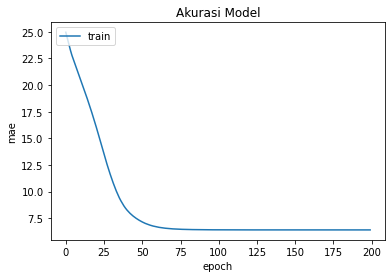

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.title('Akurasi Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()